<a href="https://colab.research.google.com/github/samshanmukh/Agent_POC/blob/master/Agent_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q --quiet install langchain-groq duckduckgo-search langchain-google-genai chromadb
!pip -q --quiet install -U langchain_community tiktoken langchainhub sentence-transformers
!pip -q --quiet install -U langchain langgraph tavily-python kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d thedrcat/kaggle-winning-solutions-methods

Dataset URL: https://www.kaggle.com/datasets/thedrcat/kaggle-winning-solutions-methods
License(s): CC-BY-NC-SA-4.0
 67% 5.00M/7.46M [00:00<00:00, 32.4MB/s]
100% 7.46M/7.46M [00:00<00:00, 45.8MB/s]


In [ ]:
!unzip kaggle-winning-solutions-methods.zip -d /content/drive/MyDrive/AIHackathon/data

Archive:  kaggle-winning-solutions-methods.zip
  inflating: /content/drive/MyDrive/AIHackathon/data/kaggle_winning_solutions_methods.csv  
  inflating: /content/drive/MyDrive/AIHackathon/data/kaggle_winning_solutions_methods_detail.csv  
  inflating: /content/drive/MyDrive/AIHackathon/data/method_category_mapping.csv  


In [ ]:
# !apt install libgraphviz-dev
# !pip install pygraphviz

In [ ]:
!pip show langgraph

Name: langgraph
Version: 0.0.39
Summary: langgraph
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core
Required-by: 


# The goal

Reply to a customer email
1. get the email
2. categorize the email as a "sales", "custom enquiry", "off topic", "customer complaint"
3. use the category & initial email to create keywords for a search to research info needed for the reply
4. write a draft reply
5. check the reply
7. rewrite if needed



In [ ]:
import os
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [ ]:
### Tracing (optional)
import os
from pprint import pprint

# os.environ['LANGCHAIN TRACING V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN API KEY'] = userdata.get('LANGCHAIN_API_KEY')

In [ ]:
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI


LLM_OPTION = 'GEMINI'

if LLM_OPTION == 'GROQ':
  LLM = ChatGroq(
              model="llama3-70b-8192",
          )
elif LLM_OPTION == 'GEMINI':
  LLM = ChatGoogleGenerativeAI(model="models/gemini-1.5-pro-latest")


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser

## Utils

In [ ]:
def write_markdown_file(content, filename):
  """Writes the given content as a markdown file to the local directory.

  Args:
    content: The string content to write to the file.
    filename: The filename to save the file as.
  """
  with open(f"{filename}.md", "w") as f:
    f.write(content)


def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', text)

## Embedding index

In [ ]:
from langchain_community.document_loaders import DataFrameLoader
import pandas as pd
import re


df = pd.read_csv("/content/drive/MyDrive/AIHackathon/data/kaggle_winning_solutions_methods_detail.csv")

In [ ]:
df.head()

,link,place,competition_name,prize,team,kind,metric,year,nm,writeup,num_tokens,methods,cleaned_methods
0,https://www.kaggle.com/c/asl-signs/discussion/...,2,Google - Isolated Sign Language Recognition,"$100,000","1,165",Research,PostProcessorKernelDesc,2023,406306,<h2>TLDR</h2>\n<p>We used an approach similar ...,2914,EfficientNet-B0,CNNs
1,https://www.kaggle.com/c/asl-signs/discussion/...,2,Google - Isolated Sign Language Recognition,"$100,000","1,165",Research,PostProcessorKernelDesc,2023,406306,<h2>TLDR</h2>\n<p>We used an approach similar ...,2914,Data Augmentation,Data Augmentation
2,https://www.kaggle.com/c/asl-signs/discussion/...,2,Google - Isolated Sign Language Recognition,"$100,000","1,165",Research,PostProcessorKernelDesc,2023,406306,<h2>TLDR</h2>\n<p>We used an approach similar ...,2914,Normalization,Preprocessing
3,https://www.kaggle.com/c/asl-signs/discussion/...,2,Google - Isolated Sign Language Recognition,"$100,000","1,165",Research,PostProcessorKernelDesc,2023,406306,<h2>TLDR</h2>\n<p>We used an approach similar ...,2914,Interpolation,Interpolation
4,https://www.kaggle.com/c/asl-signs/discussion/...,2,Google - Isolated Sign Language Recognition,"$100,000","1,165",Research,PostProcessorKernelDesc,2023,406306,<h2>TLDR</h2>\n<p>We used an approach similar ...,2914,BERT,Transformers


In [ ]:
df.shape

(47193, 13)

In [ ]:
df = df.drop_duplicates(["link", "writeup"])

In [ ]:
df.shape

(1262, 13)

In [ ]:
df.writeup[0]

'<h2>TLDR</h2>\n<p>We used an approach similar to audio spectrogram classification using the EfficientNet-B0 model, with numerous augmentations and transformer models such as BERT and DeBERTa as helper models. The final solution consists of one EfficientNet-B0 with an input size of 160x80, trained on a single fold from 8 randomly split folds, as well as DeBERTa and BERT trained on the full dataset. A single fold model using EfficientNet has a CV score of 0.898 and a leaderboard score of ~0.8.</p>\n<p>We used only competition data.</p>\n<h2>1. Data Preprocessing</h2>\n<h3>1.1 CNN Preprocessing</h3>\n<ul>\n<li>We extracted 18 lip points, 20 pose points (including arms, shoulders, eyebrows, and nose), and all hand points, resulting in a total of 80 points.</li>\n<li>During training, we applied various augmentations.</li>\n<li>We implemented standard normalization.</li>\n<li>Instead of dropping NaN values, we filled them with zeros after normalization.</li>\n<li>We interpolated the time ax

In [ ]:
df['writeup'] = df['writeup'].map(remove_html_tags)

In [ ]:
from langchain_community.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader = DataFrameLoader(df.head(10), page_content_column="writeup")
raw_docs=loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
docs = text_splitter.split_documents(raw_docs)

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma
#from langchain.vectorstores import FAISS

model_name = "Alibaba-NLP/gte-base-en-v1.5" #"all-MiniLM-L6-v2" #"intfloat/multilingual-e5-small"
#embedding_function = SentenceTransformerEmbeddings(model_name=model_name)

model_kwargs = {'device': 'cpu', 'trust_remote_code': True}
encode_kwargs = {'normalize_embeddings': False}
embedding_function = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
#vectorstore = FAISS.from_documents(docs, embeddings)

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/57.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
vectorstore = Chroma.from_documents(docs, embedding_function, persist_directory="/content/MyDrive/chroma_db")


In [ ]:
retriever = vectorstore.as_retriever()


## Basic Chains

1. Categorize EMAIL  
2. Research Router  
3. Search Keywords  
4. Write Draft Email  
5. Rewrite Router  
6. Draft Email Analysis  
7. Rewrite Email

In [ ]:
#Categorize EMAIL
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a Email Categorizer Agent You are a master at understanding what a customer wants when they write an email and are able to categorize it in a useful way

     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Conduct a comprehensive analysis of the email provided and categorize into one of the following categories:
        price_equiry - used when someone is asking for information about pricing \
        customer_complaint - used when someone is complaining about something \
        product_enquiry - used when someone is asking for information about a product feature, benefit or service but not about pricing \\
        customer_feedback - used when someone is giving feedback about a product \
        off_topic when it doesnt relate to any other category \


            Output a single cetgory only from the types ('price_equiry', 'customer_complaint', 'product_enquiry', 'customer_feedback', 'off_topic') \
            eg:
            'price_enquiry' \

    EMAIL CONTENT:\n\n {initial_email} \n\n
    <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["initial_email"],
)

email_category_generator = prompt | LLM | StrOutputParser()

EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreaciate what your staff did

Thanks,
Paul
"""

result = email_category_generator.invoke({"initial_email": EMAIL})

print(result)

customer_feedback 



In [ ]:
## Research Router
research_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at reading the initial email and routing web search or directly to a draft email. \n

    Use the following criteria to decide how to route the email: \n\n

    If the initial email only requires a simple response
    Just choose 'draft_email'  for questions you can easily answer, prompt engineering, and adversarial attacks.
    If the email is just saying thank you etc then choose 'draft_email'

    You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use research-info.
    Give a binary choice 'research_info' or 'draft_email' based on the question. Return the a JSON with a single key 'router_decision' and
    no premable or explaination. use both the initial email and the email category to make your decision
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Email to route INITIAL_EMAIL : {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category"],
)

research_router = research_router_prompt | LLM | JsonOutputParser()

email_category = 'customer_feedback'

print(research_router.invoke({"initial_email": EMAIL, "email_category":email_category}))

{'router_decision': 'draft_email'}


In [ ]:
## Search keywords
search_keyword_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a master at working out the best keywords to search for in a web search to get the best info for the customer.

    given the INITIAL_EMAIL and EMAIL_CATEGORY. Work out the best keywords that will find the best
    info for helping to write the final email.

    Return a JSON with a single key 'keywords' with no more than 3 keywords and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category"],
)

search_keyword_chain = search_keyword_prompt | LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None

print(search_keyword_chain.invoke({"initial_email": EMAIL, "email_category":email_category}))

{'keywords': ['hotel customer feedback examples', 'positive hotel review response', 'responding to customer appreciation']}


In [ ]:
## Write Draft Email
draft_writer_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Email Writer Agent take the INITIAL_EMAIL below  from a human that has emailed our company email address, the email_category \
            that the categorizer agent gave it and the research from the research agent and \
            write a helpful email in a thoughtful and friendly way.

            If the customer email is 'off_topic' then ask them questions to get more information.
            If the customer email is 'customer_complaint' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'customer_feedback' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'product_enquiry' then try to give them the info the researcher provided in a succinct and friendly way.
            If the customer email is 'price_equiry' then try to give the pricing info they requested.

            You never make up information that hasn't been provided by the research_info or in the initial_email.
            Always sign off the emails in appropriate manner and from Sarah the Resident Manager.

            Return the email a JSON with a single key 'email_draft' and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    RESEARCH_INFO: {research_info} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","research_info"],
)

draft_writer_chain = draft_writer_prompt | LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None

print(draft_writer_chain.invoke({"initial_email": EMAIL, "email_category":email_category,"research_info":research_info}))

{'email_draft': "Dear Paul,\n\nThank you so much for taking the time to share your wonderful experience at our resort! We're thrilled to hear that you had a great stay and appreciate the efforts of our staff. We're grateful for customers like you who make our job so rewarding.\n\nWe'll make sure to pass on your kind words to our team, and we're looking forward to welcoming you back again soon.\n\nThank you again for your feedback, and we wish you all the best.\n\nBest regards,\nSarah, Resident Manager"}


In [ ]:
## Rewrite Router
rewrite_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at evaluating the emails that are draft emails for the customer and deciding if they
    need to be rewritten to be better. \n

    Use the following criteria to decide if the DRAFT_EMAIL needs to be rewritten: \n\n

    If the INITIAL_EMAIL only requires a simple response which the DRAFT_EMAIL contains then it doesn't need to be rewritten.
    If the DRAFT_EMAIL addresses all the concerns of the INITIAL_EMAIL then it doesn't need to be rewritten.
    If the DRAFT_EMAIL is missing information that the INITIAL_EMAIL requires then it needs to be rewritten.

    Give a binary choice 'rewrite' (for needs to be rewritten) or 'no_rewrite' (for doesn't need to be rewritten) based on the DRAFT_EMAIL and the criteria.
    Return the a JSON with a single key 'router_decision' and no premable or explaination. \
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    DRAFT_EMAIL: {draft_email} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","draft_email"],
)

rewrite_router = rewrite_router_prompt | LLM | JsonOutputParser()

email_category = 'customer_feedback'
draft_email = "Yo we can't help you, best regards Sarah"

print(rewrite_router.invoke({"initial_email": EMAIL, "email_category":email_category, "draft_email":draft_email}))

{'router_decision': 'rewrite'}


In [ ]:
## Draft Email Analysis
draft_analysis_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Quality Control Agent read the INITIAL_EMAIL below  from a human that has emailed \
    our company email address, the email_category that the categorizer agent gave it and the \
    research from the research agent and write an analysis of how the email.

    Check if the DRAFT_EMAIL addresses the customer's issued based on the email category and the \
    content of the initial email.\n

    Give feedback of how the email can be improved and what specific things can be added or change\
    to make the email more effective at addressing the customer's issues.

    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the analysis a JSON with a single key 'draft_analysis' and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n\n
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","research_info"],
)

draft_analysis_chain = draft_analysis_prompt | LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

email_analysis = draft_analysis_chain.invoke({"initial_email": EMAIL,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email})

pprint(email_analysis)

{'draft_analysis': {'addressing_customer_issue': 'fail',
                    'feedback': 'The draft email does not acknowledge the '
                                "customer's positive feedback or express "
                                "gratitude for their kind words. It's abrupt "
                                'and unprofessional. A more suitable response '
                                'would be to thank the customer for their '
                                'feedback and let them know that their kind '
                                'words will be shared with the staff. The tone '
                                'of the draft email is also informal and does '
                                "not match the tone of the customer's email."}}


In [ ]:
# Rewrite Email with Analysis
rewrite_email_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Final Email Agent read the email analysis below from the QC Agent \
    and use it to rewrite and improve the draft_email to create a final email.


    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the final email as JSON with a single key 'final_email' which is a string and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    DRAFT_EMAIL_FEEDBACK: {email_analysis} \n\n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email",
                     "email_category",
                     "research_info",
                     "email_analysis",
                     "draft_email",
                     ],
)

rewrite_chain = rewrite_email_prompt | LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

final_email = rewrite_chain.invoke({"initial_email": EMAIL,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email,
                                "email_analysis":email_analysis})

final_email['final_email']

'Dear valued customer, thank you so much for taking the time to share your feedback with us. We truly appreciate your kind words and will make sure to share them with our staff. Your feedback is invaluable to us and we are grateful for your support. Best regards, Sarah'

## Tool Setup

In [ ]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=1)

## State

In [ ]:
from langchain.schema import Document
from langgraph.graph import END, StateGraph

In [ ]:
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        initial_email: email
        email_category: email category
        draft_email: LLM generation
        final_email: LLM generation
        research_info: list of documents
        info_needed: whether to add search info
        num_steps: number of steps
    """
    initial_email : str
    email_category : str
    draft_email : str
    final_email : str
    research_info : List[str]
    info_needed : bool
    num_steps : int
    draft_email_feedback : dict

## Nodes

1. categorize_email
2. research_info_search  
3. draft_email_writer  
4. analyze_draft_email  
5. rewrite_email  
6. no_rewrite  
7. state_printer


In [ ]:
def categorize_email(state):
    """take the initial email and categorize it"""
    print("---CATEGORIZING INITIAL EMAIL---")
    initial_email = state['initial_email']
    num_steps = int(state['num_steps'])
    num_steps += 1

    email_category = email_category_generator.invoke({"initial_email": initial_email})
    print(email_category)
    # save to local disk
    write_markdown_file(email_category, "email_category")

    return {"email_category": email_category, "num_steps":num_steps}

In [ ]:
def research_info_search(state):

    print("---RESEARCH INFO SEARCHING---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Web search
    keywords = search_keyword_chain.invoke({"initial_email": initial_email,
                                            "email_category": email_category })
    keywords = keywords['keywords']
    # print(keywords)
    full_searches = []
    for keyword in keywords[:1]:
        print(keyword)
        temp_docs = web_search_tool.invoke({"query": keyword})
        web_results = "\n".join([d["content"] for d in temp_docs])
        web_results = Document(page_content=web_results)
        if full_searches is not None:
            full_searches.append(web_results)
        else:
            full_searches = [web_results]
    print(full_searches)
    print(type(full_searches))
    # write_markdown_file(full_searches, "research_info")
    return {"research_info": full_searches, "num_steps":num_steps}

In [ ]:
def draft_email_writer(state):
    print("---DRAFT EMAIL WRITER---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email
    draft_email = draft_writer_chain.invoke({"initial_email": initial_email,
                                     "email_category": email_category,
                                     "research_info":research_info})
    print(draft_email)
    # print(type(draft_email))

    email_draft = draft_email['email_draft']
    write_markdown_file(email_draft, "draft_email")

    return {"draft_email": email_draft, "num_steps":num_steps}

In [ ]:
def analyze_draft_email(state):
    print("---DRAFT EMAIL ANALYZER---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email
    draft_email_feedback = draft_analysis_chain.invoke({"initial_email": initial_email,
                                                "email_category": email_category,
                                                "research_info":research_info,
                                                "draft_email":draft_email}
                                               )
    # print(draft_email)
    # print(type(draft_email))

    write_markdown_file(str(draft_email_feedback), "draft_email_feedback")
    return {"draft_email_feedback": draft_email_feedback, "num_steps":num_steps}

In [ ]:
def rewrite_email(state):
    print("---ReWRITE EMAIL ---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]
    draft_email_feedback = state["draft_email_feedback"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email
    final_email = rewrite_chain.invoke({"initial_email": initial_email,
                                                "email_category": email_category,
                                                "research_info":research_info,
                                                "draft_email":draft_email,
                                                "email_analysis": draft_email_feedback}
                                               )

    write_markdown_file(str(final_email), "final_email")
    return {"final_email": final_email['final_email'], "num_steps":num_steps}

In [ ]:
def no_rewrite(state):
    print("---NO REWRITE EMAIL ---")
    ## Get the state
    draft_email = state["draft_email"]
    num_steps = state['num_steps']
    num_steps += 1

    write_markdown_file(str(draft_email), "final_email")
    return {"final_email": draft_email, "num_steps":num_steps}

In [ ]:
def state_printer(state):
    """print the state"""
    print("---STATE PRINTER---")
    print(f"Initial Email: {state['initial_email']} \n" )
    print(f"Email Category: {state['email_category']} \n")
    print(f"Draft Email: {state['draft_email']} \n" )
    print(f"Final Email: {state['final_email']} \n" )
    print(f"Research Info: {state['research_info']} \n")
    print(f"Info Needed: {state['info_needed']} \n")
    print(f"Num Steps: {state['num_steps']} \n")
    return

## Conditional Edges

In [ ]:
def route_to_research(state):
    """
    Route email to web search or not.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """

    print("---ROUTE TO RESEARCH---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]


    router = research_router.invoke({"initial_email": initial_email,"email_category":email_category })
    print(router)
    # print(type(router))
    print(router['router_decision'])
    if router['router_decision'] == 'research_info':
        print("---ROUTE EMAIL TO RESEARCH INFO---")
        return "research_info"
    elif router['router_decision'] == 'draft_email':
        print("---ROUTE EMAIL TO DRAFT EMAIL---")
        return "draft_email"

In [ ]:
def route_to_rewrite(state):

    print("---ROUTE TO REWRITE---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]

    # draft_email = "Yo we can't help you, best regards Sarah"

    router = rewrite_router.invoke({"initial_email": initial_email,
                                     "email_category":email_category,
                                     "draft_email":draft_email}
                                   )
    print(router)
    print(router['router_decision'])
    if router['router_decision'] == 'rewrite':
        print("---ROUTE TO ANALYSIS - REWRITE---")
        return "rewrite"
    elif router['router_decision'] == 'no_rewrite':
        print("---ROUTE EMAIL TO FINAL EMAIL---")
        return "no_rewrite"

## Build the Graph

### Add Nodes

In [ ]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("categorize_email", categorize_email) # categorize email
workflow.add_node("research_info_search", research_info_search) # web search
workflow.add_node("state_printer", state_printer)
workflow.add_node("draft_email_writer", draft_email_writer)
workflow.add_node("analyze_draft_email", analyze_draft_email)
workflow.add_node("rewrite_email", rewrite_email)
workflow.add_node("no_rewrite", no_rewrite)



### Add Edges

In [ ]:
workflow.set_entry_point("categorize_email")

workflow.add_conditional_edges(
    "categorize_email",
    route_to_research,
    {
        "research_info": "research_info_search",
        "draft_email": "draft_email_writer",
    },
)
workflow.add_edge("research_info_search", "draft_email_writer")


workflow.add_conditional_edges(
    "draft_email_writer",
    route_to_rewrite,
    {
        "rewrite": "analyze_draft_email",
        "no_rewrite": "no_rewrite",
    },
)
workflow.add_edge("analyze_draft_email", "rewrite_email")
workflow.add_edge("no_rewrite", "state_printer")
workflow.add_edge("rewrite_email", "state_printer")
workflow.add_edge("state_printer", END)

In [ ]:
# Compile
app = workflow.compile()


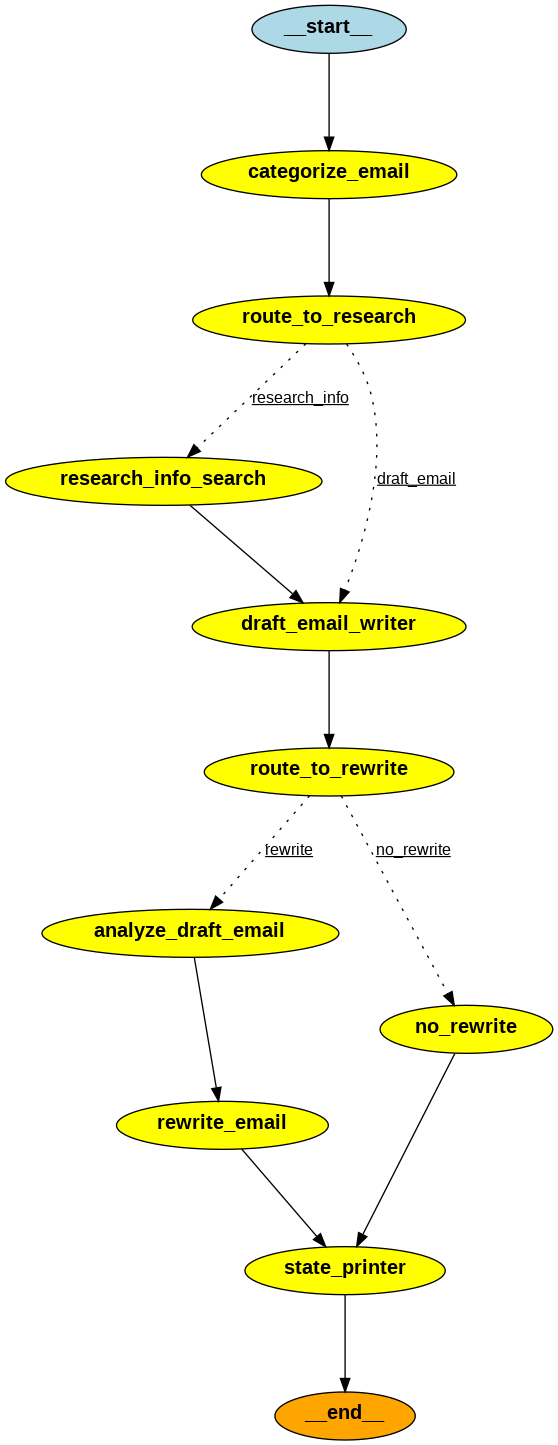

In [ ]:
from IPython.display import display, HTML
import base64

def display_image(image_bytes: bytes, width=400):
    decoded_img_bytes = base64.b64encode(image_bytes).decode('utf-8')
    html = f'<img src="data:image/png;base64,{decoded_img_bytes}" style="width: {width}px;" />'
    display(HTML(html))

display_image(app.get_graph().draw_png())

In [ ]:
# EMAIL = """HI there, \n
# I am emailing to find out the current price of Bitcoin. \n

# Can you please help me/

# Thanks,
# John
# """

EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreaciate what your staff did

Thanks,
Paul
"""

EMAIL = """HI there, \n
I am emailing to say that the resort weather was way to cloudy and overcast. \n
I wanted to write a song called 'Here comes the sun but it never came'

What should be the weather in Arizona in April?

I really hope you fix this next time.

Thanks,
George
"""

# EMAIL = """HI there, \n
# Why can't I get to sing?

# Thanks,
# Ringo
# """

# EMAIL = """HI there, \n
# Thanks for confirming my booking

# Thanks,
# Ringo
# """

In [ ]:
# run the agent
inputs = {"initial_email": EMAIL,"research_info": None, "num_steps":0}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}")

---CATEGORIZING INITIAL EMAIL---
'customer_complaint'
---ROUTE TO RESEARCH---
{'router_decision': 'research_info'}
research_info
---ROUTE EMAIL TO RESEARCH INFO---
("Finished running: categorize_email: {'email_category': "
 '"\'customer_complaint\'", \'num_steps\': 1}')
---RESEARCH INFO SEARCHING---
Arizona weather April
[Document(page_content="{'location': {'name': 'Arizona Village', 'region': 'Arizona', 'country': 'United States of America', 'lat': 34.85, 'lon': -114.58, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1714178102, 'localtime': '2024-04-26 17:35'}, 'current': {'last_updated_epoch': 1714177800, 'last_updated': '2024-04-26 17:30', 'temp_c': 20.0, 'temp_f': 68.0, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 9.4, 'wind_kph': 15.1, 'wind_degree': 350, 'wind_dir': 'N', 'pressure_mb': 1005.0, 'pressure_in': 29.68, 'precip_mm': 0.15, 'precip_in': 0.01, 'humidity': 39, 'cloud': 0, 'feelslike_

In [ ]:
output = app.invoke(inputs)

print(output['final_email'])

---CATEGORIZING INITIAL EMAIL---
'customer_complaint'
---ROUTE TO RESEARCH---
{'router_decision': 'research_info'}
research_info
---ROUTE EMAIL TO RESEARCH INFO---
---RESEARCH INFO SEARCHING---
Arizona weather April
[Document(page_content="{'location': {'name': 'Arizona', 'region': 'Atlantida', 'country': 'Honduras', 'lat': 15.63, 'lon': -87.32, 'tz_id': 'America/Tegucigalpa', 'localtime_epoch': 1714178359, 'localtime': '2024-04-26 18:39'}, 'current': {'last_updated_epoch': 1714177800, 'last_updated': '2024-04-26 18:30', 'temp_c': 29.0, 'temp_f': 84.2, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 11.9, 'wind_kph': 19.1, 'wind_degree': 70, 'wind_dir': 'ENE', 'pressure_mb': 1009.0, 'pressure_in': 29.8, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 70, 'cloud': 25, 'feelslike_c': 34.9, 'feelslike_f': 94.7, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 7.0, 'gust_mph': 12.6, 'gust_kph': 20.3}}\nExtend

In [ ]:
!cat /content/email_category.md

'customer_complaint'

In [ ]:
!cat /content/draft_email.md

Dear George,

Thank you for reaching out to us about your recent experience at our resort. I apologize that the weather didn't quite live up to your expectations. I can understand why you'd want to write a song about the sun not coming out!

Regarding your question, in April, Phoenix, Arizona typically experiences average high temperatures ranging from 75°F to 90°F (24°C to 32°C) and average low temperatures between 50°F to 60°F (10°C to 15°C).

I appreciate your feedback, and I assure you that we're taking your concerns seriously. We'll do our best to ensure that our future guests have a more pleasant experience.

Thank you again for sharing your thoughts with us. If you have any further concerns or questions, please don't hesitate to reach out.

Best regards,
Sarah, Resident Manager